In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df_train = pd.read_csv('train.csv')
df_train

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [4]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [5]:
#!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

In [6]:
#!unzip glove.6B.zip

In [7]:
embedding_index = {}
f = open('/content/glove.6B.50d.txt', 'r', encoding ='utf-8')
for line in tqdm(f):
  values = line.split(' ')
  word = values[0]
  coesf = np.asarray([float(val) for val in values[1:]])
  embedding_index[word] = coesf
f.close()

400000it [00:07, 51796.30it/s]


Converts the remaining elements of values (the vector components) into a NumPy array of floats. Each value is converted to a float using a list comprehension.
Adds the word as a key and its corresponding vector as the value to the embedding_index dictionary.

In [ ]:
embedding_index

In [9]:
len(embedding_index)

400000

In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#**Preprocessing - Vectorization**

In [11]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize('listening to sad songs on a monday morning')

['listening', 'to', 'sad', 'songs', 'on', 'a', 'monday', 'morning']

In [12]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('feet')

'foot'

In [13]:
stops = set(stopwords.words('english'))

In [14]:
df_train['final_text']  = df_train['tweet']
df_train

,id,label,tweet,final_text
0,1,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...","@user #sikh #temple vandalised in in #calgary,..."


In [15]:
# Remove url
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove punct
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove html
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Seperate alphanumeric
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0)

    if len(tchr) > 1:
        return tchr[0:2]

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute



In [16]:
# Apply functions on tweets
df_train['final_text'] = df_train['final_text'].apply(lambda x : remove_username(x))
df_train['final_text'] = df_train['final_text'].apply(lambda x : remove_url(x))
df_train['final_text'] = df_train['final_text'].apply(lambda x : remove_emoji(x))
df_train['final_text'] = df_train['final_text'].apply(lambda x : seperate_alphanumeric(x))
df_train['final_text'] = df_train['final_text'].apply(lambda x : unique_char(cont_rep_char,x))
df_train['final_text'] = df_train['final_text'].apply(lambda x : char(x))



In [17]:
df_train['final_text']

0        when a father is dysfunctional and is so selfi...
1        thanks for lyft credit i can t use cause they ...
2                                      bihday your majesty
3        model i love u take with u all the time in ur ...
4                        factsguide society now motivation
                               ...                        
31957              ate isz that youu                      
31958    to see nina turner on the airwaves trying to w...
31959    listening to sad songs on a monday morning otw...
31960    sikh temple vandalised in in calgary wso conde...
31961                             thank you for you follow
Name: final_text, Length: 31962, dtype: object

In [18]:
def Preprocessing_one(s):
  tokens = tokenizer.tokenize(s)
  tokens_lower = [x.lower() for x in tokens ]
  tokens_lower_stop = [x for x in tokens_lower if not x in stops]
  tokens_lemmatized = [lemmatizer.lemmatize(x) for x in tokens_lower_stop]
  useful_tokens = [x for x in tokens_lemmatized if x in embedding_index]
  return useful_tokens

In [19]:
def combine_vectorization(text, glove = embedding_index):
  text_preprocessed = Preprocessing_one(text)
  vectors = []

  for token in text_preprocessed:
    if token not in glove:
      continue
    token_vec = glove[token]
    vectors.append(token_vec)

  return np.array(vectors, dtype='float')

In [20]:

print(combine_vectorization('listening to sad songs on a Mondaysss Morning').shape)

(5, 50)


# **Spliting Data**

In [21]:
df_train = df_train.sample(frac=1, random_state=1231)
df_train.reset_index(drop=True, inplace=True)

split_index_1 = int(len(df_train) * 0.7)
split_index_2 = int(len(df_train) * 0.85)

train_df, val_df, test_df = df_train[:split_index_1], df_train[split_index_1:split_index_2], df_train[split_index_2:]

len(train_df), len(val_df), len(test_df)

(22373, 4794, 4795)

# **Preparing data and Pad Sequence**

In [22]:
def prepare_x_y(data):

  y = data['label'].to_numpy().astype(int)

  all_vec_seq = []

  for text in data['final_text']:
    text_as_vector_seq = combine_vectorization(text)

    if text_as_vector_seq.shape[0] == 0:
      text_as_vector_seq = np.zeros(shape= (1, 50))

    all_vec_seq.append(text_as_vector_seq)

  return all_vec_seq, y

In [23]:
xtrain, ytrain = prepare_x_y(train_df)
print(len(xtrain))

22373


In [24]:
xtest, ytest = prepare_x_y(test_df)
print(len(xtest))

4795


In [25]:
X_val, y_val = prepare_x_y(val_df)
print(len(X_val))

4794


In [26]:
def pad_sequence(text, desired_sequence_lenght= 57):
  xcopy = deepcopy(text)

  for i , x in enumerate(text):
    x_seq_len = x.shape[0]
    sequence_lenght_difference = desired_sequence_lenght - x_seq_len

    pad = np.zeros(shape=(sequence_lenght_difference, 50))

    xcopy[i] = np.concatenate([x, pad])

  return np.array(xcopy).astype(float)

In [27]:
xtrain_pad = pad_sequence(xtrain)
xtrain_pad.shape

(22373, 57, 50)

In [28]:
xtest_pad = pad_sequence(xtest)
xtest_pad.shape

(4795, 57, 50)

In [29]:
xval_pad = pad_sequence(X_val)
xval_pad.shape

(4794, 57, 50)

# **LSTM MODEL**

In [30]:

model = Sequential([])

model.add(layers.Input(shape=(57, 50)))
model.add(layers.LSTM(256, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(256, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LayerNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LayerNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LayerNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss= BinaryCrossentropy(),  metrics=['accuracy' ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 57, 256)           314368    
                                                                 
 dropout (Dropout)           (None, 57, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 57, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 57, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 57, 128)           197120    
                                                                 
 layer_normalization (LayerN  (None, 57, 128)          256       
 ormalization)                                                   
                                                        

In [31]:
weights = class_weight.compute_class_weight(class_weight='balanced' ,classes= np.unique(ytrain) , y = df_train['label'].to_numpy().astype(int))
weights = {i : weights[i] for i in range(2)}
weights

{0: 0.5377187079407806, 1: 7.128010704727921}

In [32]:
history = model.fit(xtrain_pad, ytrain, validation_data=(xtest_pad, ytest), epochs=100, class_weight=weights)

Epoch 1/100
700/700 [==============================] - 43s 33ms/step - loss: 0.6298 - accuracy: 0.7174 - val_loss: 0.2355 - val_accuracy: 0.9070
Epoch 2/100
700/700 [==============================] - 20s 28ms/step - loss: 0.4974 - accuracy: 0.7940 - val_loss: 0.3884 - val_accuracy: 0.8486
Epoch 3/100
700/700 [==============================] - 21s 31ms/step - loss: 0.4594 - accuracy: 0.8121 - val_loss: 0.3524 - val_accuracy: 0.8467
Epoch 4/100
700/700 [==============================] - 20s 28ms/step - loss: 0.4138 - accuracy: 0.8314 - val_loss: 0.3392 - val_accuracy: 0.8838
Epoch 5/100
700/700 [==============================] - 22s 32ms/step - loss: 0.3941 - accuracy: 0.8377 - val_loss: 0.3008 - val_accuracy: 0.8774
Epoch 6/100
700/700 [==============================] - 21s 31ms/step - loss: 0.3592 - accuracy: 0.8487 - val_loss: 0.2555 - val_accuracy: 0.8899
Epoch 7/100
700/700 [==============================] - 21s 30ms/step - loss: 0.3478 - accuracy: 0.8545 - val_loss: 0.2305 - val_ac

# **Evaluation**

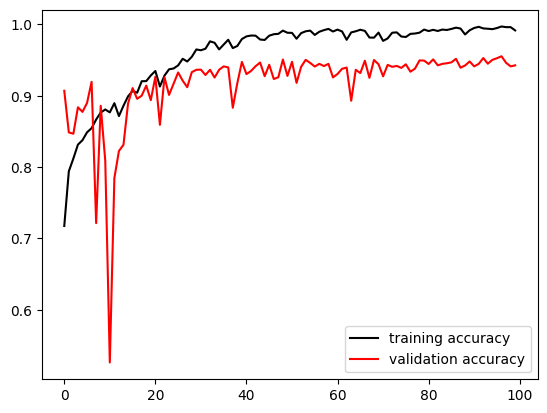

In [37]:
plt.plot(history.history["accuracy"], label="training accuracy", color = 'black')
plt.plot(history.history["val_accuracy"], label="validation accuracy", color = 'red')
plt.legend()
plt.show()

In [34]:
ypred = (model.predict(xval_pad) > 0.5).astype(int)
ypred

150/150 [==============================] - 4s 10ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_val, ypred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4438
           1       0.57      0.68      0.62       356

    accuracy                           0.94      4794
   macro avg       0.77      0.82      0.79      4794
weighted avg       0.94      0.94      0.94      4794



In [38]:
model.evaluate(xval_pad, y_val)

150/150 [==============================] - 2s 12ms/step - loss: 0.2902 - accuracy: 0.9387


[0.29021236300468445, 0.9386733174324036]